# Evaluación de resultados

En este notebook se muestran técnicas para la evaluación de los resultados de una predicción con un algoritmo de Machine Learning

## Conjunto de datos

### Descripción
NSL-KDD es un conjunto de datos propuesto para resolver algunos de los problemas inherentes del conjunto de datos KDD'99. Aunque esta nueva versión del conjunto de datos KDD aún sufre algunos de los problemas discutidos por McHugh y puede no ser un representante perfecto de las redes reales existentes, debido a la falta de conjuntos de datos públicos para sistemas de detección de intrusiones basados en redes, creemos que aún puede aplicarse como un conjunto de datos de referencia eficaz para ayudar a los investigadores a comparar diferentes métodos de detección de intrusiones. Además, el número de registros en los conjuntos de entrenamiento y prueba de NSL-KDD es razonable. Esta ventaja hace que sea asequible ejecutar los experimentos en el conjunto completo sin la necesidad de seleccionar aleatoriamente una pequeña porción. En consecuencia, los resultados de la evaluación de diferentes trabajos de investigación serán consistentes y comparables.

### Ficheros de datos
* <span style="color:green">**KDDTrain+.ARFF**: The full NSL-KDD train set with binary labels in ARFF format</span>
* KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
* KDDTrain+_20Percent.ARFF:	A 20% subset of the KDDTrain+.arff file
* KDDTrain+_20Percent.TXT:	A 20% subset of the KDDTrain+.txt file
* KDDTest+.ARFF:	The full NSL-KDD test set with binary labels in ARFF format
* KDDTest+.TXT:	The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
* KDDTest-21.ARFF:	A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
* KDDTest-21.TXT:	A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

### Descarga de los ficheros de datos
https://drive.google.com/file/d/1_GlmaiqbxscpWMCIdg8KSjQWsNfvkAQp/view?usp=sharing

### Referencias adicionales sobre el conjunto de datos
_M. Tavallaee, E. Bagheri, W. Lu, and A. Ghorbani, “A Detailed Analysis of the KDD CUP 99 Data Set,” Submitted to Second IEEE Symposium on Computational Intelligence for Security and Defense Applications (CISDA), 2009._

## Imports

In [2]:
import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

## Funciones auxiliares

In [3]:
#TODO función para cargar el dataset

def load_kdd_dataset(data_path):
    """Lectura del conjunto de datos NSL-KDD."""
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
    attributes = [attr[0] for attr in dataset["attributes"]]
    return pd.DataFrame(dataset["data"], columns=attributes)

In [4]:
#TODO función para dividir el dataset en los subconjuntos de train, val y test

def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [5]:
#TODO construcción de un pipeline para los atributos numéricos

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('rbst_scaler', RobustScaler()),
    ])

In [26]:
#TODO transormador para codificar únicamente las columnas categoricas y devolver un df
class CustomOneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse_output=False)  # Cambia sparse a sparse_output
        self._columns = None

    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)


In [41]:
#TODO transformador que prepara todo el conjunto de datos llamando pipelines y
#transformadores personalizados

class DataFramePreparer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self._full_pipeline = None
        self._columns = None
        
    def fit(self, X, y=None):
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        self._full_pipeline = ColumnTransformer([
                ("num", num_pipeline, num_attribs),
                ("cat", CustomOneHotEncoding(), cat_attribs),
        ])
        self._full_pipeline.fit(X)
        self._columns = pd.get_dummies(X).columns
        return self
        
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

## Lectura del conjunto de datos

In [42]:
#TODO llama a la función para cargar tu dataset en un dataframe

df = load_kdd_dataset("../../datasets/NSL-KDD/KDDTrain+.arff")

In [43]:
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## División del conjunto de datos

In [44]:
#TODO llama a la función para realizar la division del conjunto de
# datos en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(df, stratify='protocol_type')

In [45]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 75583
Longitud del Validation Set: 25195
Longitud del Test Set: 25195


Para cada uno de los subconjuntos, separamos las etiquetas de las características de entrada.

In [46]:
# Conjunto de datos general
X_df = df.drop("class", axis=1)
y_df = df["class"].copy()


In [47]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

In [48]:
# Conjunto de datos de validación
X_val = val_set.drop("class", axis=1)
y_val = val_set["class"].copy()

In [49]:
# Conjunto de datos de pruebas
X_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

## Preparación del conjunto de datos

In [50]:
#TODO instanciamos nuestro transformador personalizado
preparer = DataFramePreparer()


In [51]:
# TODO hacemos el fit con el conjunto de datos general para que adquiera
# todos los valores posibles
preparer.fit(X_df)


DataFramePreparer()

In [54]:
#TODO transformamos el subconjunto de datos de entrenamiento
X_train_prep = preparer.transform(X_train)

In [55]:
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
113467,0.0,tcp,http,SF,407.0,53508.0,0,0.0,0.0,0.0,...,9.0,255.0,1.00,0.00,0.11,0.03,0.0,0.0,0.0,0.0
31899,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,4.0,0.02,0.05,0.00,0.00,1.0,1.0,0.0,0.0
108116,0.0,tcp,http,SF,304.0,636.0,0,0.0,0.0,0.0,...,39.0,255.0,1.00,0.00,0.03,0.06,0.0,0.0,0.0,0.0
89913,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,15.0,0.06,0.07,0.00,0.00,1.0,1.0,0.0,0.0
106319,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,7.0,1.00,0.00,1.00,0.57,0.0,0.0,0.0,0.0


In [56]:
X_train_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
113467,0.0,1.315217,103.697674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
31899,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
108116,0.0,0.942029,1.232558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
89913,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
106319,0.0,-0.130435,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [57]:
#TODO transformamos el subconjunto de datos de validacion
X_val_prep = preparer.transform(X_val)

## Entrenamiento de un algoritmo de Regresión Logística

La instanciación de un algoritmo de Machine Learning utilizando Sklearn se realiza utilizando los métodos expuestos por la API de sklearn tal y como se ha presentado en cuadernos anteriores. En este caso vamos a pedirle al modelo que se entrene durante más tiempo, concretamente 1.000 iteraciones.

In [63]:
from sklearn.linear_model import LogisticRegression
#TODO entrenamos un algoritmo basado en regresión logística
# Prueba cambiando los hiperparámetros, por ejemplo, solver="newton-cg" y max_iter=1000 al instanciar LogisticRegression 
# para obtener mejores métricas (por ejemplo, F1 Score por la que puntuaremos)
# Más info en: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

clf = LogisticRegression(solver="newton-cg", max_iter=1000)

# Entrenar el modelo con el conjunto de entrenamiento
clf.fit(X_train_prep, y_train)

LogisticRegression(max_iter=1000, solver='newton-cg')

## Predicción de nuevos ejemplos

Realizamos una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de Regresión Logística. Utilizamos el subconjunto de validación.

In [64]:
y_pred = clf.predict(X_val_prep)

## 1. Matriz de Confusión

In [65]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

array([[11321,   448],
       [  235, 13191]])

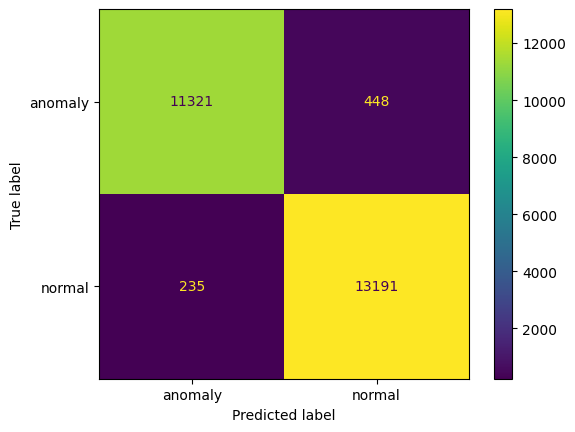

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_val_prep, y_val, values_format='d')

## 2. Métricas derivadas de la matriz de confusión

### Precisión

In [67]:
from sklearn.metrics import precision_score

print("Precisión:", precision_score(y_val, y_pred, pos_label='anomaly'))

Precisión: 0.9796642436829353


### Recall

In [68]:
from sklearn.metrics import recall_score

print("Recall:", recall_score(y_val, y_pred, pos_label='anomaly'))

Recall: 0.961933894128643


### F1 Score

In [69]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_val, y_pred, pos_label='anomaly'))

F1 score: 0.9707181136120043


## 3. Curvas ROC y PR

### Curva ROC

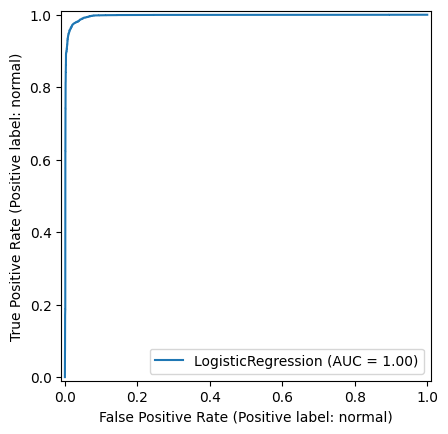

In [70]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_val_prep, y_val)

### Curva PR

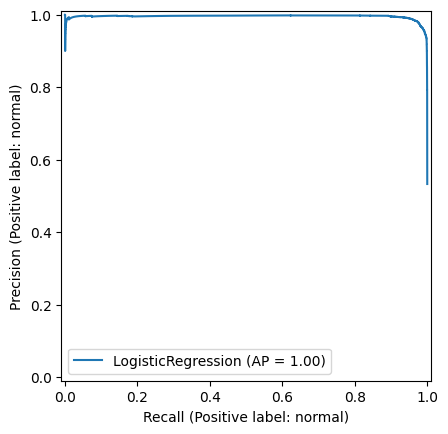

In [71]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_val_prep, y_val)

## 4. Evaluación del modelo con el conjunto de datos de pruebas

In [73]:
# Transformamos el subconjunto de datos de validacion
X_test_prep = preparer.transform(X_test)

In [74]:
y_pred = clf.predict(X_test_prep)

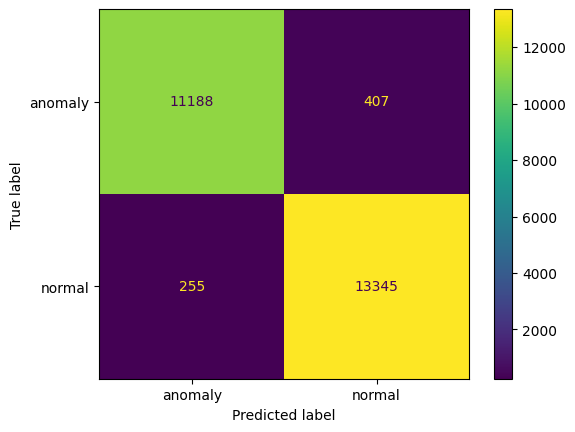

In [75]:
ConfusionMatrixDisplay.from_estimator(clf, X_test_prep, y_test, values_format='d')

In [76]:
print("F1 score:", f1_score(y_test, y_pred, pos_label='anomaly'))

F1 score: 0.9712648667419047
